In [48]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import stats
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Retrieve training data

In [49]:
X_train = pd.read_csv('X_train.csv', index_col=0)

pickle_in = open('y_train.pickle', 'rb')
y_train = pickle.load(pickle_in)

### OLS One Time Function

In [50]:
def onetime_ols(X_train, y_train):
    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()
    
    return est, results

### OLS Loop Function

In [51]:
def ols_loop(X_train, y_train, run):

    # Create x constants
    Xconst = sm.add_constant(X_train)

    # Create OLS model and summary
    ols_model = sm.OLS(y_train, Xconst, hasconst= True)
    est = ols_model.fit()
    results = est.summary()

    # Capture r2_adj 
    r2_adj = est.rsquared_adj

    # Load summary info into dataframe for processing
    results_as_html = results.tables[1].as_html()
    results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
    results_df = results_df.reset_index()
    results_df = results_df.rename(columns={'index':'feature'})
    results_df = results_df[1:]

    # Identify highest p-value in data set
    kill_cols = results_df[results_df['P>|t|'] == results_df['P>|t|'].max()]
    highest_p_col = kill_cols['feature'].values
    highest_p = kill_cols['P>|t|'].values

    # Remove feature with highest p-value
    X_chop = X_train.drop(columns=highest_p_col)

    # Capture values from test in dictionary
    run_dict = {'test_run': run, \
            'r2_adj': r2_adj, \
            'highest_feature': highest_p_col,\
            'highest_pval': highest_p[0]}
    
    return X_chop, run_dict

### View initial residual plot for a basline look at the residuals in the regression

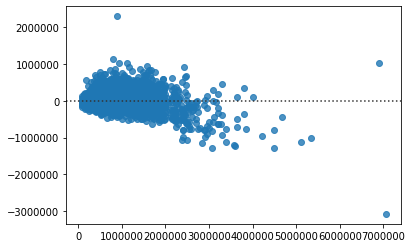

In [52]:
ot_est, results = onetime_ols(X_train, y_train)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

onetime_ols(X_train, y_train)

y_pred = ot_est.predict()

sns.residplot(x=y_train, y=y_pred);

### It appears there are __outliers to be removed__.  This inlcude the y_train values around 7,000,000 and the y_train value corresponding to the maximum y_pred value

Remove y_train outliers

In [59]:
ind = np.argpartition(y_train, -1)[-2:]
print(ind)
print(y_train[ind])

# y_train2 = np.delete(y_train, 7358, 0)
# y_train2 = np.delete(y_train2, 2194, 0)

[16147  7358]
[ 467000. 7060000.]


In [60]:
# x_train2 = X_train.drop(index=7358)

In [61]:
# x_train2 = x_train2.drop(index=2194)

In [62]:
x_train2.shape

(16147, 252)

In [63]:
y_train2.shape

(16147,)

In [64]:
# ind = np.argpartition(y_pred, -1)[-5:]
# print(ind)
# print(y_pred[ind])

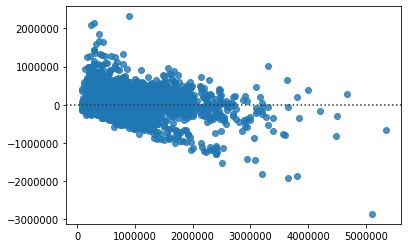

In [66]:
ot_est, results = onetime_ols(x_train2, y_train2)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

onetime_ols(x_train2, y_train2)

y_pred = ot_est.predict()

sns.residplot(x=y_train2, y=y_pred);

### Loop for recursive feature elimination
Loops removes the highest p_value from an OLS regression and returns the R2 adjusted value and removed feature name

In [73]:
run = 0
for run in range(1, 136):
    if run == 1:
        x_chop, run_dict = ols_loop(x_train2, y_train2, run)
        all_df = pd.DataFrame.from_dict([run_dict])
#         print('Run {} complete'.format(run))
    else:
        x_chop, run_dict = ols_loop(x_chop, y_train2, run)
        run_df = pd.DataFrame.from_dict([run_dict])
        all_df = pd.concat([all_df, run_df])

        #         print('Run {} complete'.format(run))

### Review the recursive feature elimination

In [74]:
all_df;

### Review columns returned from ols loop analysis

In [76]:
ot_est, results = onetime_ols(x_chop, y_train2)
results_as_html = results.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})

results_df;

In [77]:
x_chop.columns
x_model = X_train[x_chop.columns]
x_model = x_model.reset_index()

y_pred = ot_est.predict()

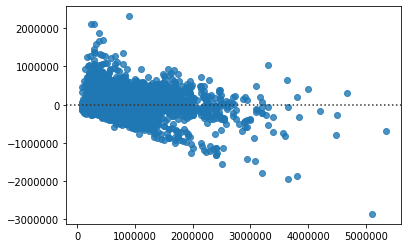

In [78]:
sns.residplot(x=y_train2, y=y_pred);

In [ ]:
results_df;

In [ ]:
model_features = keep_features['feature'][1:].values

In [ ]:
len(model_features)

In [ ]:
model_df_train = X_train[model_features]
model_df_train.shape

In [ ]:
Xconst = sm.add_constant(model_df_train)

ols_model2 = sm.OLS(y_train, Xconst, hasconst= True)
est2 = ols_model2.fit()
results2 = est2.summary()

results_as_html = results2.tables[1].as_html()
results_df = pd.read_html(results_as_html, header=0, index_col=0)[0]

results_df = results_df.reset_index()
results_df = results_df.rename(columns={'index':'feature'})
results_df['abs_t'] = results_df['t'].abs()
results2